# <img src="https://img.icons8.com/bubbles/100/000000/3d-glasses.png" style="height:50px;display:inline"> EE 046746 - Technion - Computer Vision


## Homework 1 - Features Descriptors
---

### <a style='color:red'> Due Date: 04.12.2024 </a>

### <img src="https://img.icons8.com/bubbles/50/000000/upload-to-cloud.png" style="height:50px;display:inline"> Submission Guidelines
---
#### READ THIS CAREFULLY
* Submission only in **pairs**, on the course website (Moodle). Please refer farther explanation [here](https://moodle.technion.ac.il/mod/groupselect/view.php?id=1066844).  


* You can choose your working environment:
    1. `Jupyter Notebook`, locally with <a href="https://www.anaconda.com/distribution/">Anaconda</a> or online on <a href="https://colab.research.google.com/">Google Colab</a>
        * Colab also supports running code on GPU, so if you don't have one, Colab is the way to go. To enable GPU on Colab, in the menu: `Runtime`$\rightarrow$ `Change Runtime Type`$\rightarrow$`GPU`.
    2. Python IDE such as <a href="https://www.jetbrains.com/pycharm/">PyCharm</a> or <a href="https://code.visualstudio.com/">Visual Studio Code</a>.
        * Both allow editing and running Jupyter Notebooks.


* You should submit two **separated** files:
    1. A compressed `.zip` file, with the name: `ee046746_hw1_id1_id2.zip`, which contains the followings:
        - A folder named `code` with all the code files inside (`.py` or `.ipynb` ONLY!). It is advisable to separate into folders, according to the parts of the exercise (e.g. Part A, Part B), although for this assignment it might be easier to submit a single notebook containing all parts which is also fine.
        - A folder named `output` with all the output files you are requested throughout the assignment.
        - The code should run on every computer and require no special preparation.
    2. A report file with the name `ee046746_hw1_id1_id2.pdf`.
        - This report will include an explanation of the exercise and how it was run, answers to questions if there were, conclusions and visual results.
    
> Important Notes:    
>* No other file-types (`.docx`, `.html`, ...) will be accepted.
>* **No handwritten submissions**.


### <img src="https://img.icons8.com/dusk/64/000000/python.png" style="height:50px;display:inline"> Python Libraries
---

* `numpy`
* `matplotlib`
* `opencv` (or `scikit-image`)
* `scikit-learn`
* `scipy`
* Anything else you need (`os`, `pandas`, `csv`, `json`,...)

### <img src="https://img.icons8.com/bubbles/50/000000/checklist.png" style="height:50px;display:inline"> Tasks
---
* In all tasks, you should document your process and results in a report file (which will be saved as `.pdf`). 
* You can reference your code in the report file, but no need for actual code in this file, the code is submitted in a seprate folder as explained above.

#### Introduction 
---
In this homework, we will implement an interest point (keypoint) detector similar to SIFT. Then, we will describe the region around each keypoint using a feature descriptor.
In class, we have seen the SIFT keypoint extraction and description extraction. In this HW, we will implement the BRIEF, which is another commonly used feature descriptor.
The BRIEF is more compact and quicker, which allows real-time computation. Additionally, its performance is powerful just as more complex descriptors like SIFT for many cases.

#### Part 1 - Keypoint Detector
---
The first part will include implementing an interest point detector, similar to SIFT. Additional details for the chosen implementation can be found in <a href="https://people.eecs.berkeley.edu/~malik/cs294/lowe-ijcv04.pdf">[2]</a>. 
In order to find keypoints, we will use the Difference of Gaussian (DoG) detector <a href="https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=1095851">[1]</a>. We will use a simplified version of (DoG) as described in section 3 of <a href="https://people.eecs.berkeley.edu/~malik/cs294/lowe-ijcv04.pdf">[2]</a>. 

NOTE: The parameters to use for the following sections are:
$$\sigma_0 = 1, k =\sqrt 2, levels = [-1; 0; 1; 2; 3; 4], \theta_c = 0.03 \text{ and } \theta_r = 12$$



In [5]:
# imports for hw1 (you can add any other library as well)
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy
import sklearn
from scipy.io import savemat, loadmat

In [ ]:
# Define data path according to root directory:
import os

if os.getcwd().split('/')[-1] == 'code':
    data_path = '../data/'
else:
    data_path = 'data/'

##### 1.1 Load Image
Load the `model_chickenbroth.jpg` image and show it:

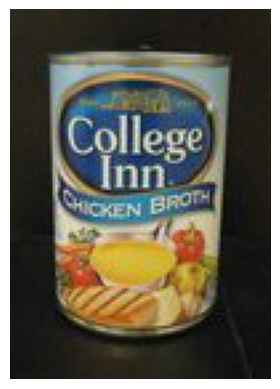

In [6]:
im = cv2.imread(data_path + 'model_chickenbroth.jpg')
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
_ = plt.axis('off')

##### 1.2 Gaussian Pyramid
Before we construct a DoG pyramid, we need to construct a Gaussian Pyramid by progressively applying a low pass Gaussian filter to the input image.
We provide you the following function `createGaussianPyramid` which gets a grayscale image with values between 0 to 1 (hint: normalize your input image and convert to grayscale). This function outputs GaussianPyramid matrix, which is a set of $L=len(levels)$ blurred images.

What is the shape of GaussianPyramid matrix?

In [7]:
def createGaussianPyramid(im, sigma0, k, levels):
    GaussianPyramid = []
    for i in range(len(levels)):
        sigma_ = sigma0 * k ** levels[i]
        size = int(np.floor( 3 * sigma_ * 2) + 1)
        blur = cv2.GaussianBlur(im,(size,size),sigma_)
        GaussianPyramid.append(blur)
    return np.stack(GaussianPyramid)

Use the following function to visualize your pyramid. 
* Add the results to your PDF report.

In [8]:
def displayPyramid(pyramid):
    plt.figure(figsize=(16,5))
    plt.imshow(np.hstack(pyramid), cmap='gray')
    plt.axis('off')

Short example of using the above functions:

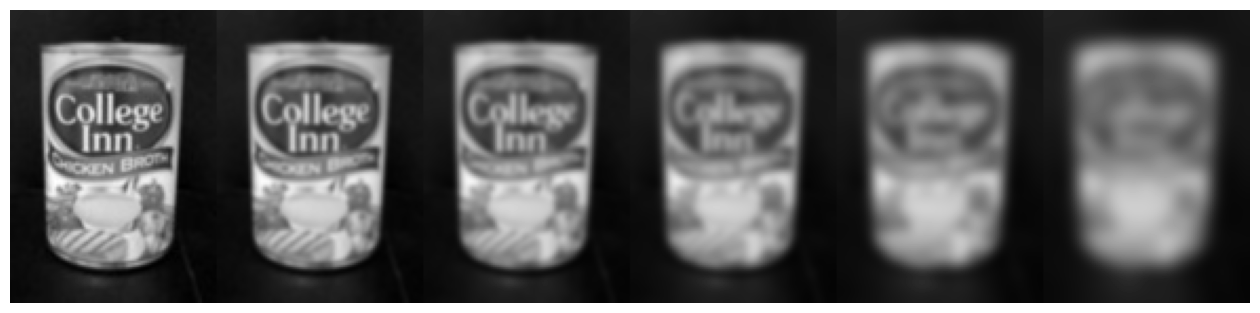

In [9]:
# example:
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
im = im / 255
sigma0 = 1
k = np.sqrt(2)
levels = [-1, 0, 1, 2, 3, 4]
GaussianPyramid =  createGaussianPyramid(im, sigma0, k, levels) 
displayPyramid(GaussianPyramid)

The shape of the Gaussian Pyramid is:

In [10]:
GaussianPyramid.shape

(6, 139, 98)

##### 1.3 The DoG Pyramid
In this section we will construct the DoG pyramid. Each level of the DoG is constructed by substructing two levels of the Gaussian pyramid:

$$D_l(x,y,\sigma_l) = (G(x,y,\sigma_{l-1})-G(x,y,\sigma_l))*I(x,y)$$

Where $G(x,y,\sigma_l)$ is the Gaussian filter used at level $l$ in the Gaussian pyramid, $I(x,y)$ is the original image, and $*$ is the *convolution* operator.

We can simplify the equation due to the distributive property of convolution:

$$D_l(x,y,\sigma_l) = G(x,y,\sigma_{l-1})*I(x,y)-G(x,y,\sigma_l)*I(x,y)=GP_{l-1}-GP_{l}$$

Where $GP_l$ is the level $l$ in the Gaussian pyramid.

<img src="../assets/Gaussian_DoG_pyramid.PNG" width="400">

* Write the following function to constract a DoG pyramid:

In [55]:
def createDoGPyramid(GaussianPyramid, levels):
    # Produces DoG Pyramid
    # INPUTS
    # GaussianPyramid - A matrix of grayscale images of size
    #                    (len(levels), shape(im))
    # levels          - the levels of the pyramid where the blur at each level is.
    # OUTPUTS
    # DoGPyramid      - size (len(levels) - 1, shape(im)) matrix of the DoG pyramid
    #                   created by differencing the Gaussian Pyramid input
    # DogLevels       - the levels of the pyramid where the blur at each level corresponds
    #                   to the DoG scale
    DoGPyramid = []
    DoGLevels = levels[:-1]
    # following the ewquation DoG = G(i-1) - G(i):
    for i in range(1, len(levels)):
        DoGPyramid.append(GaussianPyramid[i-1] - GaussianPyramid[i])
    DoGPyramid = np.stack(DoGPyramid)
    return DoGPyramid, DoGLevels

This function should return DoGPyramid an $(L-1)\times imH \times imW$ matrix, where $imH\times imW$ is the original image resolution.

(5, 139, 98)


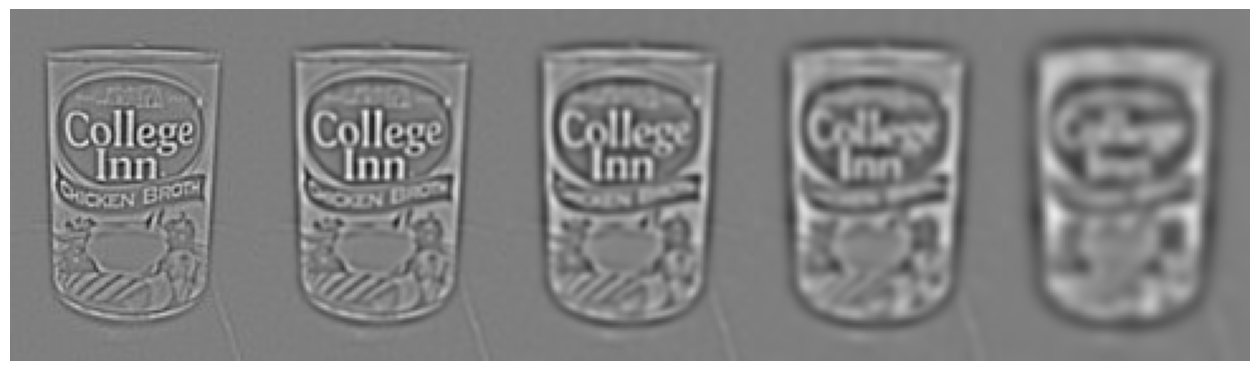

In [57]:
# example:
DoGPyramid, DoGLevels = createDoGPyramid(GaussianPyramid, levels)
displayPyramid(DoGPyramid)
print(DoGPyramid.shape)

##### 1.4 Edge Suppression
The Difference of Gaussian function responds strongly on corners and edges in addition to blob-like objects. However, edges are not desirable for feature extraction as they are not as distinctive and do not provide a substantially stable localization for keypoints.

Here, we will implement the edge removal method described in Section 4.1 of <a href="https://people.eecs.berkeley.edu/~malik/cs294/lowe-ijcv04.pdf">[2]</a>, which is based on the principal curvature ratio in a local neighborhood of a point. The paper presents the observation that edge points will have a "large principal curvature across
the edge but a small one in the perpendicular direction."


* Implement the following function:

In [12]:
def computePrincipalCurvature(DoGPyramid):
    # Edge Suppression
    #  Takes in DoGPyramid generated in createDoGPyramid and returns
    #  PrincipalCurvature,a matrix of the same size where each point contains the
    #  curvature ratio R for the corresponding point in the DoG pyramid
    # 
    #  INPUTS
    #  DoG Pyramid - size (len(levels) - 1, shape(im)) matrix of the DoG pyramid
    # 
    #  OUTPUTS
    #  PrincipalCurvature - size (len(levels) - 1, shape(im)) matrix where each 
    #                       point contains the curvature ratio R for the 
    #                       corresponding point in the DoG pyramid
    epsilon = 1e-8
    PrincipalCurvature = []

    for dog in DoGPyramid:
        # Compute the second order derivatives with Sobel filters
        Dxx = cv2.Sobel(dog, cv2.CV_64F, 2, 0, ksize=3)
        Dyy = cv2.Sobel(dog, cv2.CV_64F, 0, 2, ksize=3)
        Dxy = cv2.Sobel(dog, cv2.CV_64F, 1, 1, ksize=3)

        # Compute trace and determinant for each pixel
        trace = Dxx + Dyy
        det = Dxx * Dyy - Dxy ** 2

        # Compute curvature ratio R
        R = (trace ** 2) / (det + epsilon)
        PrincipalCurvature.append(R)
    
    return np.stack(PrincipalCurvature)

The function takes in DoGPyramid generated in the previous section and returns PrincipalCurvature, a matrix of the same size where each point contains the curvature ratio R for the corresponding point in the DoG pyramid:

$ R = \frac{TR(H)^2}{Det(H)} = \frac{(\lambda_{min}+\lambda_{max})^2}{\lambda_{min}\lambda_{max}}$

where H is the Hessian of the Difference of Gaussian function (i.e. one level of the DoG pyramid) computed by using pixel differences as mentioned in Section 4.1 of [2]. **Use the Sobel filter to  compute the second order derivatives** (hint: `cv2.Sobel()`).

$ H = \begin{bmatrix}
D_{xx} & D_{xy}\\
D_{yx} & D_{yy}
\end{bmatrix}$

This is similar in spirit to but different than the Harris corner detection matrix you saw in class. Both methods examine the eigenvalues $\lambda$ of a matrix, but the method in <a href="https://people.eecs.berkeley.edu/~malik/cs294/lowe-ijcv04.pdf">[2]</a> performs a test without requiring the direct computation of the eigenvalues. Note that you need to compute each term of the Hessian before being able to take the trace and
determinant. Feel free to implement the mathemtical formulas of $TR(H)$ and $Det(H)$ directly without explicitly building $H$. In addition, to avoid division by zero, please add a safeguard $\epsilon=10^{-8}$ to the denominator of $R$.

We can see that $R$ reaches its minimum when the two eigenvalues $\lambda_{min}$ and $\lambda_{max}$ are equal, meaning that the curvature is the same in the two principal directions. Edge points, in general, will have a principal curvature significantly larger in one direction than the other. To remove edge points, we simply check against a threshold $R > \theta_r$. In addition, in the unlikely event of a negative determinant we also discard points for which $R < 0$.
<!-- Fig. 3 shows t
he DoG detector with and without edge suppression. -->

##### 1.5 Detecting Extrema
To detect corner-like, scale-invariant interest points, the DoG detector chooses points that are local extrema in both scale and space. Here, we will consider a point’s eight neighbors in space and its two neighbors in scale (one in the scale above and one in the scale below).

<img src="../assets/DoG_neighbors_10.png" width="200">

* write the function:

In [ ]:
def getLocalExtrema(DoGPyramid, DoGLevels, PrincipalCurvature, 
                    th_contrast, th_r): 
    # Returns local extrema points in both scale and space using the DoGPyramid
    # INPUTS
    #       DoGPyramid         - size (len(levels) - 1, imH, imW ) matrix of the DoG pyramid
    #       DoGlevels          - The levels of the pyramid where the blur at each level is
    #                            outputs
    #       PrincipalCurvature - size (len(levels) - 1, imH, imW) matrix contains the
    #                            curvature ratio R
    #       th_contrast        - remove any point that is a local extremum but does not have a
    #                            DoG response magnitude above this threshold
    #       th_r               - remove any edge-like points that have too large a principal
    #                            curvature ratio
    # OUTPUTS
    #       locsDoG            - N x 3 matrix where the DoG pyramid achieves a local extrema in both
    #                            scale and space, and also satisfies the two thresholds.
    
    l,m,n = DoGPyramid.shape
    extremas = []

    # Iterate over each level of the DoG Pyramid:
    for i in range(l):
        
        # Compute Maxima and Minima within 3x3x3 neighborhood:
        maxima = scipy.ndimage.maximum_filter(DoGPyramid[i], size=3, mode='nearest') == DoGPyramid[i]
        minima = scipy.ndimage.minimum_filter(DoGPyramid[i], size=3, mode='nearest') == DoGPyramid[i]

        # Consider scale neighbors within DoGPyramid:
        if i>0:
            maxima = maxima & (DoGPyramid[i] > DoGPyramid[i-1])
            minima = minima & (DoGPyramid[i] < DoGPyramid[i-1])
        if i<len(DoGPyramid)-1:
            maxima = maxima & (DoGPyramid[i] > DoGPyramid[i+1])
            minima = minima & (DoGPyramid[i] < DoGPyramid[i+1])

        # Compute extrema:
        extrema = (maxima | minima)

        # Remove points below contrast threshold:
        extrema = extrema & (np.abs(DoGPyramid[i]) > th_contrast)

        # Remove points above principal curvature threshold:
        extrema = extrema & (np.abs(PrincipalCurvature[i]) < th_r)

        # Get indices of extrema:
        y, x = np.where(extrema)
        levels = np.ones_like(x) * DoGLevels[i]

        # Append to extremas list:
        if len(x) > 0:
            extremas.append(np.stack([x, y, levels], axis=1))

    if len(extremas) == 0:
        return np.array([])
    
    locsDoG = np.vstack(extremas)
    return locsDoG

In [157]:
locsDoG = getLocalExtrema(DoGPyramid, DoGLevels, computePrincipalCurvature(DoGPyramid), 0.03, 12)
print(locsDoG.shape)

(351, 3)


This function takes as input `DoGPyramid` and `DoGLevels` from Section 1.3 and `PrincipalCurvature` from Section 1.4. It also takes two threshold values, `th_contrast` and `th_r`. The threshold $\theta_c$ should remove any point that is a local extremum but does not have a Difference
of Gaussian (DoG) response magnitude above this threshold (i.e. $|D(x, y, \sigma)| > \theta_c$). The threshold $\theta_r$ should remove any edge-like points that have too large a principal curvature ratio specified by `PrincipalCurvature`.

The function should return `locsDoG`, a $N \times 3$ matrix ($N$ is the number of the detected extrema points) where the DoG pyramid achieves a local extrema in both scale and space, and also satisfies the two thresholds. The first and second column of `locsDoG` should be the $(x, y)$ values of the local extremum and the third column should contain the corresponding level of the DoG pyramid where it was detected (try to eliminate loops in the function so that it runs efficiently).

**NOTE**: In all implementations, we assume the $x$ coordinate corresponds to
columns and $y$ coordinate corresponds to rows. For example, the coordinate
$(10, 20)$ corresponds to the (row 20, column 10) in the image.




##### 1.6 Putting it Together
* Write the following function to combine the above parts into a DoG detector:

In [129]:
def DoGdetector(im, sigma0, k, levels, th_contrast=0.03, th_r=12):
    #     Putting it all together
    #     Inputs          Description
    #     --------------------------------------------------------------------------
    #     im              Grayscale image with range [0,1].
    #     sigma0          Scale of the 0th image pyramid.
    #     k               Pyramid Factor.  Suggest sqrt(2).
    #     levels          Levels of pyramid to construct. Suggest -1:4.
    #     th_contrast     DoG contrast threshold.  Suggest 0.03.
    #     th_r            Principal Ratio threshold.  Suggest 12.
    #     Outputs         Description
    #     --------------------------------------------------------------------------
    #     locsDoG         N x 3 matrix where the DoG pyramid achieves a local extrema
    #                     in both scale and space, and satisfies the two thresholds.
    #     gauss_pyramid   A matrix of grayscale images of size (len(levels),imH,imW)
    
    GaussianPyramid =  createGaussianPyramid(im, sigma0, k, levels) 
    DoGPyramid, DoGLevels = createDoGPyramid(GaussianPyramid, levels)
    PrincipalCurvature = computePrincipalCurvature(DoGPyramid)
    locsDoG = getLocalExtrema(DoGPyramid, DoGLevels, PrincipalCurvature, th_contrast, th_r)

    return locsDoG, GaussianPyramid

The function should take in a grayscale image, `im`, scaled between 0 and 1, and the parameters `sigma0, k, levels, th_contrast`, and `th_r`. It should use each of the above functions and return the keypoints in `locsDoG` and the Gaussian pyramid in `GaussianPyramid`.
Note that we are dealing with real images here, so your keypoint detector may find points with high scores that you do not perceive to be corners.

* For sanity check, use the provided image `sanitycheck.jpg`. Since this image contains only simple geometrical shapes, the detection result should be a perfect detection of all corners:

<img src="../assets/sanitycheck_detections2.png" width="400">

* Include another real image with the detected keypoints in your PDF report. You can use any of the real provided images.
* Take a step outside, take a picture, and apply your keypoints detector. Do you get reasonable results? How can you improve the results? Add the result and discussion to your report.

In [130]:
# Original Parameters:
sigma0 = 1
k = np.sqrt(2)
levels = [-1, 0, 1, 2, 3, 4]
theta_c = 0.03
theta_r = 12

In [131]:
def plot_keypoints(im, locs):
    """
    Show image with found keypoints
    im: image
    locs: keypoints
    """
    plt.imshow(im, cmap='gray')
    plt.scatter(locs[:, 0], locs[:, 1], s=10, c='r', marker='o')
    plt.axis('off')

def plot_side_by_side(im1, locs):
    """
    Show original image and image with found keypoints side by side
    im1: image
    locs: keypoints
    """
    plt.figure(figsize=(8, 5))
    plt.subplot(1, 2, 1)    
    plt.title("Original Image", fontsize=10)
    plt.imshow(im, cmap='gray')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title("Image with Keypoints", fontsize=10)
    plt.imshow(im, cmap='gray')
    plt.scatter(locs[:, 0], locs[:, 1], s=10, c='r', marker='o')
    plt.axis('off')

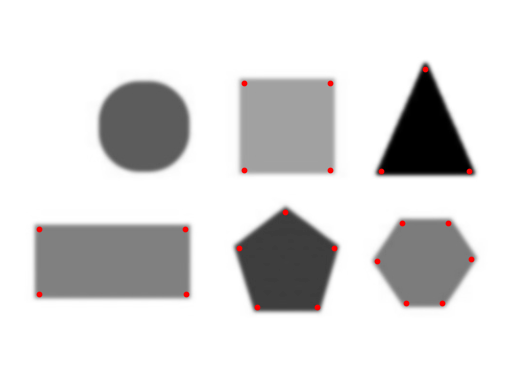

In [132]:
# ------- Sanity Check Image -------

# Grayscale normalized Image:
im = cv2.imread(data_path + 'sanitycheck.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
im = im / 255

locsDoG, GaussianPyramid = DoGdetector(im, sigma0, k, levels, theta_c, theta_r)
plot_keypoints(im, locsDoG)

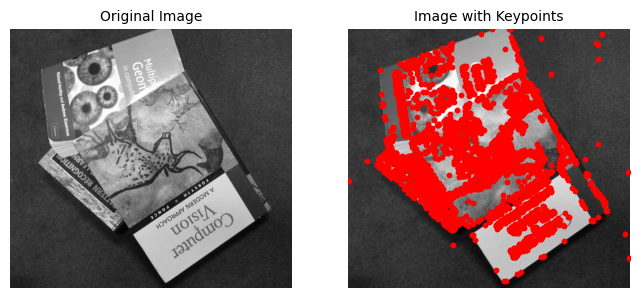

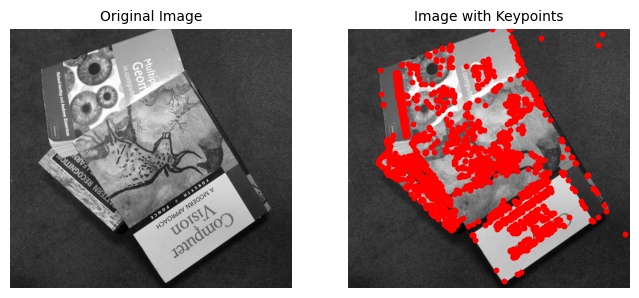

In [133]:
# ------- Additional Example Image -------

# Grayscale normalized Image:
im = cv2.imread(data_path + 'pf_pile.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
im = im / 255

locsDoG, GaussianPyramid = DoGdetector(im, sigma0, k, levels, theta_c, theta_r)
plot_side_by_side(im, locsDoG)

# ------- Improve hyperparameters -------
theta_c_new = 0.04
theta_r_new = 12

locsDoG, GaussianPyramid = DoGdetector(im, sigma0, k, levels, theta_c_new, theta_r_new)
plot_side_by_side(im, locsDoG)

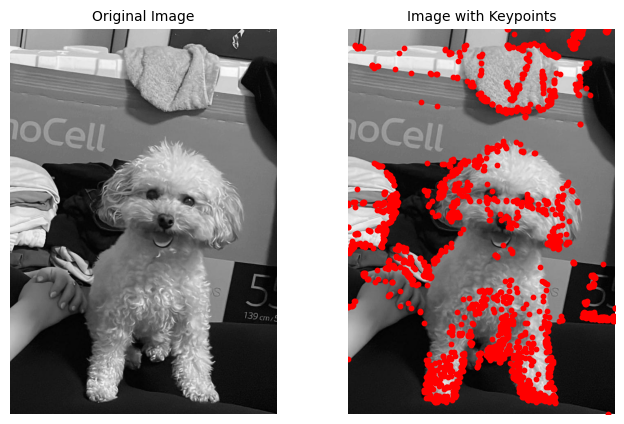

In [134]:
# ------- Real Example Image -------

# Grayscale normalized Image:
im = cv2.imread(data_path + 'my_data/alma.jpeg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
im = im / 255

locsDoG, GaussianPyramid = DoGdetector(im, sigma0, k, levels, theta_c, theta_r)
plot_side_by_side(im, locsDoG)

#### Part 2 - BRIEF Descriptor
---
Now that we have interest points that tell us where to find the most informative feature points in the image, we would like to describe each keypoint region with a descriptor. Then we can use those descriptors to match corresponding points between different images. The BRIEF descriptor encodes information from a 9 × 9 patch $p$ centered around the interest point (optimally at the <em>characteristic scale</em> of the
interest point). You can read more in
<a href="https://docs.opencv.org/4.5.1/dc/d7d/tutorial_py_brief.html">BRIEF</a> (Verify that you are looking at the docs for your installed version).


#### 2.1 Creating a Set of BRIEF Tests
The descriptor itself is a vector that is $n$-bits long, where each bit is the result of the following simple test:

$ \rho(p;x,y):= \begin{cases}
1, & \text{ if } p(x)<p(y) \\ 
 0, & \text{ otherwise. } \\
\end{cases}\\
\\
x,y \in N^{S^2}\\
p \in R^{S^2}
$

Where $S=9$ is the width and hight sizes of a patch $p$, so $x,y$ are each a pixel location within a flatten patch.
Set $n$ to 256 bits. There is no need to encode the test results as actual bits. It is fine to encode them as a 256 element vector.

<img src="../assets/BRIEF_test_vis.png" width="200">

There are many choices for the 256 test pairs $(x,y)$ used to compute $\rho (p; x,y)$ (each of the $n$ bits). 
The authors describe and test some of them in <a href="https://www.tugraz.at/fileadmin/user_upload/Institute/ICG/Images/team_lepetit/publications/calonder_eccv10.pdf">[3]</a>. Read section 3.2 of that paper and implement one of these solutions. You should generate a static set of test pairs and save that data to a file. You will use these pairs for all subsequent computations of the BRIEF descriptor.

* Write the function to create the $x$ and $y$ pairs that we will use for comparison to compute $\rho$ :

In [135]:
def makeTestPattern(patchWidth, nbits):
    """
    Compute a set of comparison tests for a given patch size from a Gaussian distribution.
    
    :param patchWidth: the width of the image patch
    :param nbits: the number of tests/comparisons
    :return compareX: indices for the first pixel in the comparison
    :return compareY: indices for the second pixel in the comparison
    """
    np.random.seed(42)
    mean = 0
    std_dev = (1/25) * patchWidth**2
    indices = np.arange(-(patchWidth**2)//2, (patchWidth**2)//2)
    
    # Gaussian distribution according to method 2:
    probabilities = np.exp(-0.5 * ((indices - mean) / std_dev) ** 2)
    probabilities /= np.sum(probabilities)

    # Randomly sample pairs of indices according to the probabilities:
    samples = np.random.choice(indices, size=(nbits, 2), p=probabilities)
    compareX = samples[:, 0] + (patchWidth**2)//2
    compareY = samples[:, 1] + (patchWidth**2)//2

    return compareX, compareY

In [136]:
patchWidth = 9
nbits = 256

res = makeTestPattern(patchWidth, nbits)
savemat('testPattern.mat', {'compareX': res[0], 'compareY': res[1]})

`patchWidth` is the width of the image patch (usually 9) and `nbits` is the number of tests $n$ in the BRIEF descriptor. `compareX` and `compareY` are linear indices into the `patchWidth` $\times$ `patchWidth` image patch and are each `nbits` $\times$ 1 vectors. Run this routine for the given parameters `patchWidth = 9` and `n = 256` and save the results in `testPattern.mat`. You can use `scipy.io.savemat()`. <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.savemat.html#scipy.io.savemat">Read more here</a>.

* Include this file in your submission (`code` directory).

#### 2.2  Compute the BRIEF Descriptor
Now we can compute the BRIEF descriptor for the detected keypoints.
* Write the function:


In [137]:
def computeBrief(im, GaussianPyramid, locsDoG, k, levels, 
                 compareX, compareY, patchWidth):
    """
    Compute the BRIEF descriptor for the provided image and keypoints.

    :param im: the input grayscale image
    :param GaussianPyramid: the Gaussian Pyramid for the input image
    :param locsDoG: the keypoint locations provided by the DoG detector
    :param k: the k value for the Gaussian Pyramid
    :param levels: the levels array of the Pyramid
    :param compareX: predetermined indices for the first pixel in the comparison
    :param compareY: predetermined indices for the second pixel in the comparison
    :param patchWidth: the width of the image patch
    :return locs: an array of the keypoint locations
    :return desc: an array of the BRIEF descriptors
    """
    n,m = im.shape
    pad = patchWidth//2
    locs = []
    desc = []

    for keypoint in locsDoG:
        x, y, level = keypoint

        # remove points without a complete patch, as per instructions:
        if x-pad < 0 or x+pad >= m or y-pad < 0 or y+pad >= n:
            continue
        
        # calculate the patch:
        patch = GaussianPyramid[level, y-pad:y+pad+1, x-pad:x+pad+1]
        patch = patch.flatten()
        compare = patch[compareY] < patch[compareX]
        compare = compare.astype(int) # set to 0 or 1

        locs.append([x, y, levels[level]])
        desc.append(compare.reshape(-1))

    locs = np.stack(locs)
    desc = np.stack(desc)
    return locs, desc

In [138]:
im = cv2.imread(data_path + 'model_chickenbroth.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) / 255

locsDoG, GaussianPyramid = DoGdetector(im, sigma0, k, levels, theta_c, theta_r)
compareX, compareY = loadmat('testPattern.mat')['compareX'], loadmat('testPattern.mat')['compareY']

locs, desc = computeBrief(im, GaussianPyramid, locsDoG, k, levels, compareX, compareY, patchWidth)
print(locs.shape, desc.shape)

(351, 3) (351, 256)


Where `im` is a grayscale image with values from 0 to 1, `locsDoG` are the keypoint locations returned by the DoG detector from Section 1.6, `levels` are the Gaussian scale levels that were given in Section 1, and `compareX` and `compareY` are the test patterns computed in Section 2.1 and were saved into `testPattern.mat` (load them with `scipy.io.loadmat()`, <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.loadmat.html">read more</a>).

The function returns `locs`, an $m \times 3$ matrix, where the first two columns are the image coordinates of keypoints and the third column is the pyramid level of the keypoints, and desc is an $m \times n$ bits matrix of stacked BRIEF descriptors. `m` is the number of valid descriptors in the image and will vary. You may have to be careful about the input DoG detector locations since they may be at the edge of an image where we cannot extract a full patch of width `patchWidth`. Thus, the number of output locs may be less than the input `locsDoG`. 

**Note**: Its possible that you may not require all the arguments to this function to compute the desired output. They have just been provided to permit the use of any of some different approaches to solve this problem.

#### 2.3  Putting it all Together
* Write a function:


In [139]:
def briefLite(im):
    """
    Wrapper function to run the BRIEF algorithm on the provided grayscale image.

    :param im: the input grayscale image
    :return locs: an array of the keypoint locations
    :return desc: an array of the BRIEF descriptors
    """
    # Defined hyperparameters:
    sigma0, k, levels, theta_c, theta_r = 1, np.sqrt(2), [-1, 0, 1, 2, 3, 4], 0.03, 12
    patchWidth = 9

    # Generate DoG keypoints and Gaussian Pyramid:
    locsDoG, GaussianPyramid = DoGdetector(im, sigma0, k, levels, theta_c, theta_r)
    compareX, compareY = loadmat('testPattern.mat')['compareX'], loadmat('testPattern.mat')['compareY']
    locs, desc = computeBrief(im, GaussianPyramid, locsDoG, k, levels, compareX, compareY, patchWidth)
    
    return locs, desc

Which accepts a grayscale image `im` with values between 0 and 1 and returns `locs`, an $m \times 3$ matrix, where the first two columns are the image coordinates of keypoints and the third column is the pyramid level of the keypoints, and `desc`, an $ m \times n$ bits matrix of stacked BRIEF descriptors. `m` is the number of valid descriptors in the image and
will vary. `n` is the number of bits for the BRIEF descriptor.

This function should perform all the necessary steps to extract the descriptors from the image, including: (1) Load parameters and test patterns, (2) Get keypoint locations, and (3) Compute a set of valid BRIEF descriptors.

#### 2.4   Check Point: Descriptor Matching
A descriptor’s strength is in its ability to match to other descriptors generated by the same world point despite change of view, lighting, etc. The distance metric used to compute the similarity between two descriptors is critical. For BRIEF, this distance metric is the Hamming distance. The Hamming distance is simply the number of bits in two descriptors that differ. (Note that the position of the bits matters.)

To perform the descriptor matching mentioned above, we have provided you the function `briefMatch`:

In [140]:
from scipy.spatial.distance import cdist

def briefMatch(desc1, desc2, ratio=0.8):   
    #     performs the descriptor matching
    #     inputs  : desc1 , desc2 - m1 x n and m2 x n matrices. m1 and m2 are the number of keypoints in image 1 and 2.
    #                               n is the number of bits in the brief
    #               ratio         - ratio used for testing whether two descriptors should be matched.
    #     outputs : matches       - p x 2 matrix. where the first column are indices
    #                                         into desc1 and the second column are indices into desc2  
    D = cdist(np.float32(desc1), np.float32(desc2), metric='hamming')
    # find smallest distance
    ix2 = np.argmin(D, axis=1)
    d1 = D.min(1)
    # find second smallest distance
    d12 = np.partition(D, 2, axis=1)[:,0:2]
    d2 = d12.max(1)
    r = d1/(d2+1e-10)
    is_discr = r<ratio
    ix2 = ix2[is_discr]
    ix1 = np.arange(D.shape[0])[is_discr]
    matches = np.stack((ix1,ix2), axis=-1)
    return matches

Which accepts an $m1 \times n$ bits stack of BRIEF descriptors from a first image and a $m2 \times n$ bits stack of BRIEF descriptors from a second image and returns a $p \times 2$ matrix of matches, where the first column are indices into `desc1` and the second column are indices into `desc2`. Note that `m1`, `m2`, and `p` may be different sizes and $p \leq \min(m1, m2)$.

* Write a test script `testMatch` to load two of the chickenbroth images and compute feature matches. Use the provided `plotMatches` and `briefMatch` functions to visualize the result.

* Use the following function to display the matched points.

In [141]:
def plotMatches(im1, im2, matches, locs1, locs2):
    fig = plt.figure()
    # draw two images side by side
    imH = max(im1.shape[0], im2.shape[0])
    im = np.zeros((imH, im1.shape[1]+im2.shape[1]), dtype='uint8')
    im[0:im1.shape[0], 0:im1.shape[1]] = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im[0:im2.shape[0], im1.shape[1]:] = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
    plt.imshow(im, cmap='gray')
    for i in range(matches.shape[0]):
        pt1 = locs1[matches[i,0], 0:2]
        pt2 = locs2[matches[i,1], 0:2].copy()
        pt2[0] += im1.shape[1]
        x = np.asarray([pt1[0], pt2[0]])
        y = np.asarray([pt1[1], pt2[1]])
        plt.plot(x,y,'r')
        plt.plot(x,y,'g.')
    plt.show()

where `im1` and `im2` are BGR images loaded by `cv2.imread()`, `matches` is the list of matches returned by `briefMatch` and `locs1` and `locs2` are the locations of keypoints from `briefLite`.

* Save the resulting figure and submit it in your PDF report. Also, present results with the two `incline*.jpg` images and with the computer vision textbook cover page (template is in file `pf_scan_scaled.jpg`) against the other `pf_*` images. Briefly discuss any cases that perform worse or better.

* Suggestion for debugging: A good test of your code is to check that you can match an image to itself.

In [142]:
def testMatch(first_path, second_path):
    ###
    # testing the matched of two images descriptors and plotting them
    # INPUTS:
    # first path, second_path: image path for the images we want to compare
    # OUTPUTS:
    # matches:  matrix of matches, where the first column are indices into `desc1` 
    #               and the second column are indices into `desc2`.
    # ###
    org_im1 = cv2.imread(first_path)
    im1 = cv2.cvtColor(org_im1, cv2.COLOR_BGR2GRAY) / 255
    locs1, desc1 = briefLite(im1)

    org_im2 = cv2.imread(second_path)
    im2 = cv2.cvtColor(org_im2, cv2.COLOR_BGR2GRAY) / 255
    locs2, desc2 = briefLite(im2)

    matches = briefMatch(desc1, desc2)
    
    plotMatches(org_im1, org_im2, matches, locs1, locs2)

#### Results - Chickenbroth Images

Compare Model with Image 1


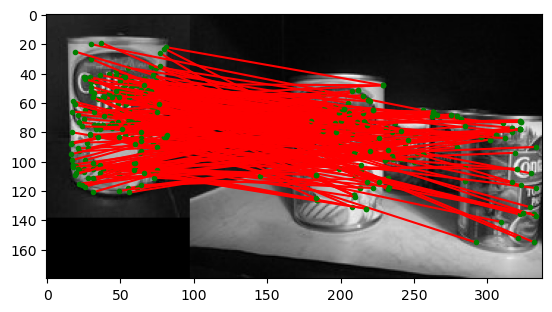

Compare Model with Image 2


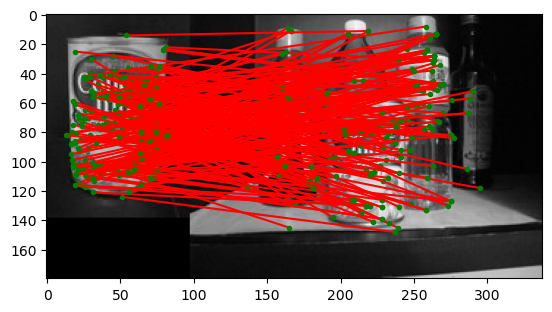

Compare Model with Image 3


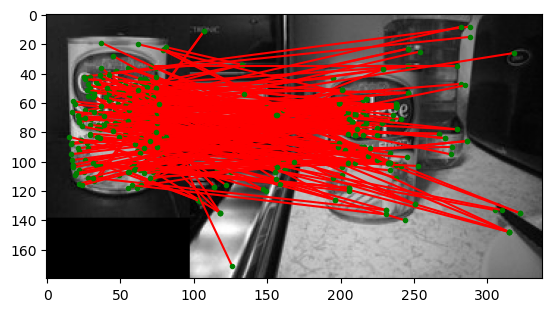

Compare Model with Image 4


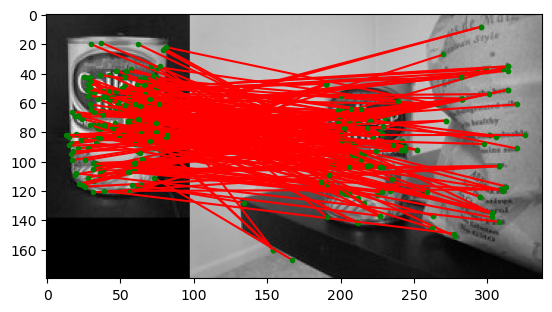

Compare Model with Image 5


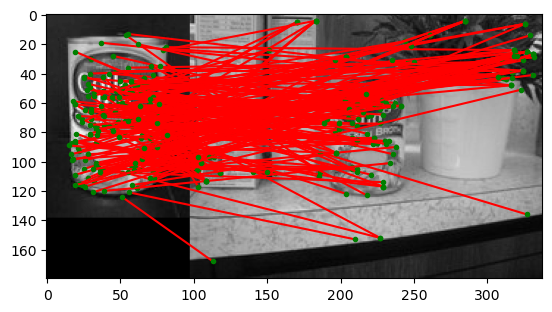

In [143]:
chickenbroth_path = data_path + "chickenbroth_0"
model_chickenbroth_path = data_path + "model_chickenbroth.jpg"
chickenbroth_images = [chickenbroth_path + str(i) + ".jpg" for i in range(1, 6)]

for i in range(0, 5):
    print(f"Compare Model with Image {i+1}")
    testMatch(model_chickenbroth_path, chickenbroth_images[i])

#### Results - Incline Images

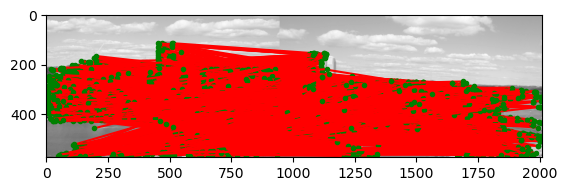

In [144]:
incline_images = [data_path+"incline_L.png", data_path+"incline_R.png"]
testMatch(incline_images[0], incline_images[1])

#### Results - pf Images

Compare scan with pf image desk


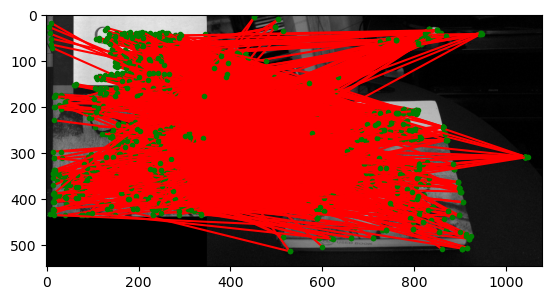

Compare scan with pf image floor_rot


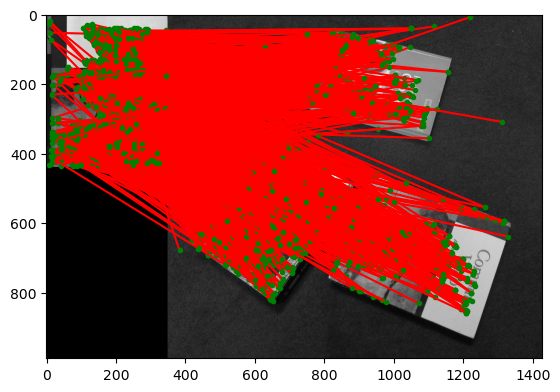

Compare scan with pf image floor


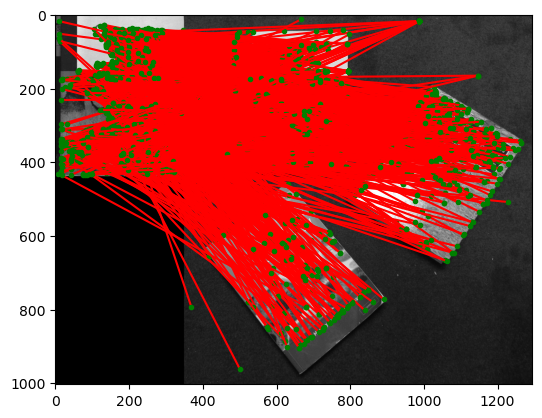

Compare scan with pf image pile


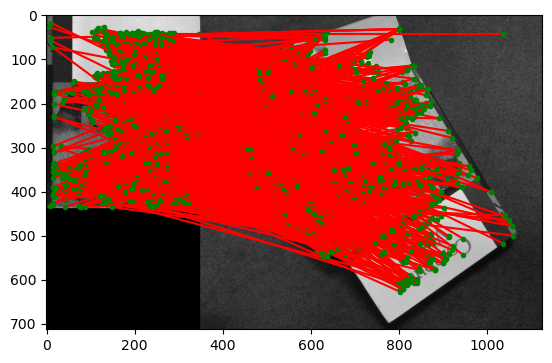

Compare scan with pf image stand


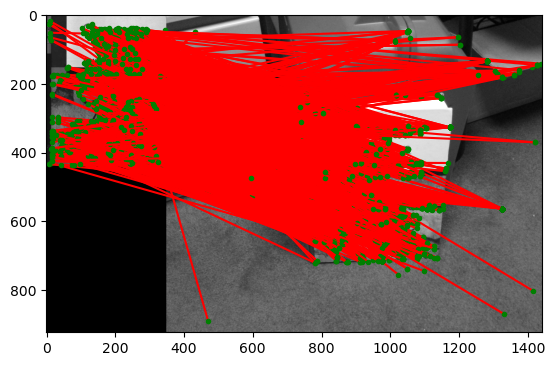

In [145]:
pf_scan_path = data_path + "pf_scan_scaled.jpg"
pf_comparison_names = ["desk", "floor_rot", "floor", "pile", "stand"]

for i in range(len(pf_comparison_names)):
    comparison_path = data_path + "pf_" + pf_comparison_names[i] + ".jpg"
    print(f"Compare scan with pf image {pf_comparison_names[i]}")
    testMatch(pf_scan_path, comparison_path)

#### 2.5   BRIEF properties

Having tested the performance of BRIEF on the provided sample images, what can you conclude regarding its limitations? Answer the following questions in your PDF report:

* Is BRIEF invariant to illumination changes?
* Assuming we want to boost the invariance of BRIEF to scale, which part of the SIFT algorithm should we include?

You may have noticed worse performance under rotations. Let’s investigate this!

* Take the `model_chickenbroth.jpg` test image and match it to itself while rotating the second image in increments of 10 degrees. Count the number of correct matches at each rotation and construct a bar graph showing rotation angle vs the number of correct matches.

* To rotate the image and calculate the new center, we have provided you the function `rotateImage`:

In [146]:
def rotateImage(image, theta):
    # rotates an image and calculates the new center pixel
    # INPUTS
    #      image      - HxW image to be rotated 
    #      theta      - rotation angle in degrees [0,360]
    # OUTPUTS
    #      image_rot  - H2xW2 rotated image 
    #      center_rot - (2,) array of the new center pixel
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2) 
    M = cv2.getRotationMatrix2D((cX, cY), -theta, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
    image_rot = cv2.warpAffine(image, M, (nW, nH))
    center_rot = (np.array(image_rot.shape[:2][::-1])-1)/2
    return image_rot, center_rot

Which accepts two input arguments: an $H \times W$ grayscale image `image` with values between 0 and 1, and an angle `theta` in degrees. This function returns `image_rot`, an $H1 \times W1$ rotated image, and $2 \times 1$ vector `center_rot`, which is the new center pixel of the grid. Note that image rotation changes the size and introduces translation of the center pixel of the grid. Hence, this needs to be taken into acount when comparing the matched keypoints.

Text(0.5, 1.0, 'Rotated')

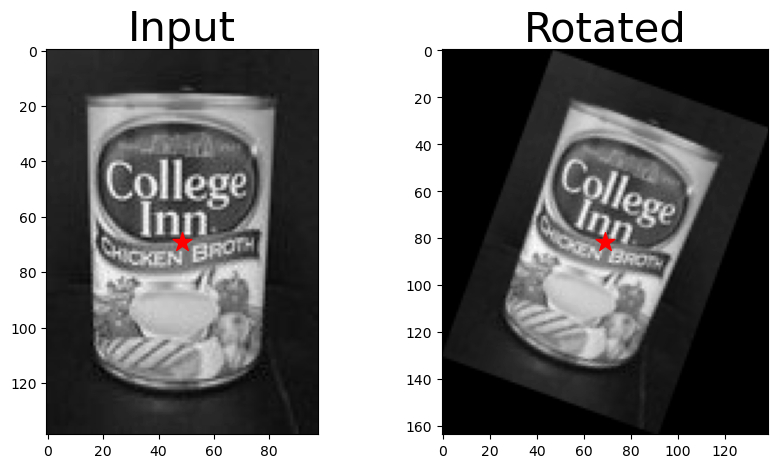

In [147]:
# example:
im = cv2.imread(data_path+'model_chickenbroth.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
im = im / 255
center = (np.array(im.shape[:2][::-1])-1)/2
theta = 20.0
im_rot, center_rot = rotateImage(im, theta)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(im, cmap="gray")
plt.scatter(center[0], center[1], 200, 'r', '*')
plt.title("Input", fontsize=30)
plt.subplot(1,2,2)
plt.imshow(im_rot, cmap="gray")
plt.scatter(center_rot[0], center_rot[1], 200, 'r', '*')
plt.title("Rotated", fontsize=30)

* Write a test script `briefRotTest` that counts the number of correct matches of the image `model_chickenbroth.jpg` as a function of rotation angle. 
* Use the provided function `checkRotLocs` to count the number of correctly matched points.

In [148]:
def checkRotLocs(locs0, locsTheta, matches, theta, 
                 c0, cTheta, th_d=9.0):
    # INPUTS
    #     locs0     - m1x3 matrix of keypoints (x,y,l) of the unrotated image
    #     locsTheta - m2x3 matrix of keypoints (x,y,l) of the rotated image
    #     matches   - px2 matrix of matches indexing into locs0 and locsTheta
    #     theta     - rotation angle in degress
    #     c0        - center of the unrotated image
    #     cTheta    - center of the rotated image
    #     th_d      - threshold distance of matched keypoints in pixels
    # OUTPUTS
    #     corrMatch - number of correct matches
    # keep only the matched keypoints (x,y)
    locs0 = locs0[matches[:,0],:2]
    locsTheta = locsTheta[matches[:,1],:2]
    # rotate the locations at theta=0 and shift them to the new center
    theta = np.deg2rad(theta)
    rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
                        [np.sin(theta), np.cos(theta)]])
    locs0_rot = (rot_mat@(locs0-c0).T).T+cTheta
    # count the number of correct matches with a distance threshold Td
    corrMatch = np.sum(np.sqrt(np.sum((locs0_rot-locsTheta)**2, 1)) < th_d)
    return corrMatch

This function takes as input the following: the detected keypoints `locs0` in the unrotated image ($m1 \times 3$ matrix of $(x,y,l)$), the detected keypoints `locsTheta` in the rotated image ($m2 \times 3$ matrix of $(x,y,l)$), the computed matches `matches` using the function `briefMatch` ($p \times 2$ matrix), the rotation angle `theta` in degrees, the center of the unrotated image `c0`, the center of the rotated image `cTheta`, and a distance threshld in pixels `th_d`. This threshold is used to decide whether the keypoints `locs0` after rotation and shift are matched correctly to the detected keypoints in the rotated image `locsTheta` (i.e. $|T_{\theta}(xy_0) - xy_{\theta}| < \theta_d$). (Suggested value `th_d=9.0`).

The function returns the number of correct matches `corrMatch` which is a scalar.

* Include the resulting bar plot in your PDF and explain why you think the descriptor behaves this way.

In [149]:
def briefRotTest(img_path, theta):
    im = cv2.imread(img_path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) / 255

    center0 = (np.array(im.shape[:2][::-1])-1)/2
    locs0, desc0 = briefLite(im)

    im_rot, center_rot = rotateImage(im, theta)
    locs_rot, desc_rot = briefLite(im_rot)

    matches = briefMatch(desc0, desc_rot)

    corrMatch = checkRotLocs(locs0, locs_rot, matches, theta, center0, center_rot)
    return corrMatch

In [150]:
# Iterate over 0 to 360 degrees in steps of 10 degrees:
img_path = data_path + 'model_chickenbroth.jpg'
result_counts = []
for theta in range(0, 360, 10):
    result_counts.append(briefRotTest(img_path, theta))

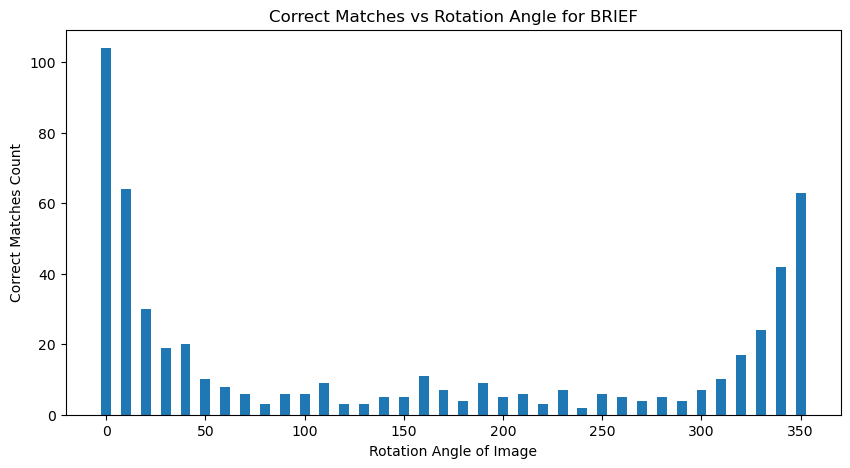

In [151]:
# Bar plot of the results with larger bar width:
plt.figure(figsize=(10, 5))
plt.bar(range(0, 360, 10), result_counts, width=5)
plt.xlabel('Rotation Angle of Image')
plt.ylabel('Correct Matches Count')
plt.title('Correct Matches vs Rotation Angle for BRIEF')
plt.show()

#### 2.6   Oriented Fast and Rotated BRIEF (ORB)

As you saw in the previous section BRIEF is not rotation-invariant. This is where ORB <a href="http://www.gwylab.com/download/ORB_2012.pdf">[4]</a> comes into play. ORB is basically a fusion of FAST keypoint detector and BRIEF descriptor with many modifications to enhance the performance (<a href="https://docs.opencv.org/4.5.1/d1/d89/tutorial_py_orb.html">read more here</a>). 

* Repeat the previous task with the ORB descriptor using OpenCV `cv2.ORB_create()`, and compare your results with section 2.5.
* Implementaton guidance:
    * Use `orb = cv2.ORB_create()` to instantiate the ORB detector and `orb.detectAndCompute()` to detect keypoints and compute descriptors.
    * Match the detected keypoints using OpenCV brute-force matcher `cv2.BFMatcher()` (<a href="https://docs.opencv.org/4.5.1/dc/dc3/tutorial_py_matcher.html">read more here</a>).
    * Compute the number of correct matches using the function `checkRotLocs` from section 2.5. Use the provided function `openCV2numpy` to access the attributes of the "DMatch" objects returned by OpenCV matcher, and transfer them to numpy arrays. 

In [152]:
# translate openCV to our data structs
def openCV2numpy(kp1, kp2, matches):
    # function transfers OpenCV keypoints and matches to numpy arrays
    # INPUTS
    #     kp1        - keypoints detected for img 1 using orb.detectAndCompute()
    #     kp2        - keypoints detected for img 2 using orb.detectAndCompute()
    #     matches    - matches returned by cv2.BFMatcher()
    # OUTPUTS
    #     locs1      - m1x3 matrix of keypoints (x,y,l)
    #     locs2      - m2x3 matrix of keypoints (x,y,l)
    #     matches_np - px2 matrix indexing into locs1 and locs2
    
    locs1 = np.array([[kp1[idx].pt[0],kp1[idx].pt[1], float(kp1[idx].octave)] 
                      for idx in range(0, len(kp1))]).reshape(-1, 3)
    locs2 = np.array([[kp2[idx].pt[0],kp2[idx].pt[1], float(kp2[idx].octave)] 
                      for idx in range(0, len(kp2))]).reshape(-1, 3)
    matches_np = [[mat.queryIdx, mat.trainIdx] for mat in matches]
    matches_np = np.stack(matches_np)
    return locs1, locs2, matches_np

This function takes as input the detected "Keypoint" objects: `kp1` in image 1, and `kp2` in image 2 (using `orb.detectAndCompute()`), and their "DMatch" objects `matches` (using `cv2.BFMatcher()`). The function returns the detected keypoints and matches in numpy arrays: `locs1` ($m1 \times 3$ matrix of $(x,y,l)$) for image 1, `locs2` ($m2 \times 3$ matrix of $(x,y,l)$) for image 2, and `matches_np` ($p \times 2$ matrix).

**Note**: OpenCV functions expect to recieve images in BGR format. Therefore, you may pass in images after they are transfered back into `uint8` and converted using `cv2.cvtColor(., cv2.COLOR_GRAY2BGR)`.

* Write a test script `orbTest` that counts the number of correct matches of the image `model_chickenbroth.jpg` as a function of rotation angle using the ORB descriptor.
* Include the resulting bar plot in your PDF and explain the key differences that make ORB rotation-invariant compared to BRIEF. Which components in ORB are borrowed from SIFT?
* Suggestion for debugging - You can visualize the returned list of "DMatch" objects by `cv2.BFMatcher()` using the OpenCV function `cv2.drawMatches()`. To make visual inspection easier, you can sort the matches and look only at the `K` (e.g. 10-20) strongest ones.

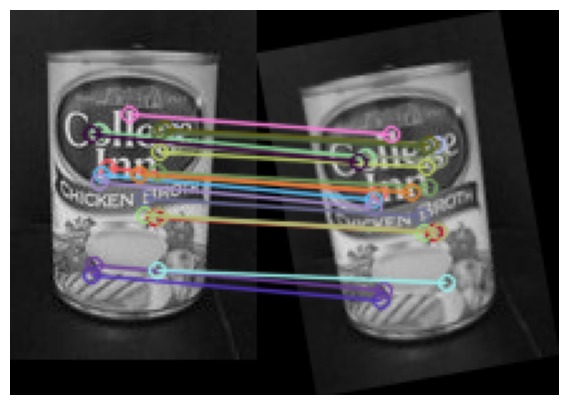

In [153]:
### ---- debugging ----

# original image
im1 = cv2.imread(data_path + 'model_chickenbroth.jpg')
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
# rotate image
im2, center_rot = rotateImage(im1, theta)

# Initiate ORB detector
orb = cv2.ORB_create()

# detect keypoints and compute descriptors
kp1, des1 = orb.detectAndCompute(im1, None)
kp2, des2 = orb.detectAndCompute(im2, None)

# Match descriptors
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)

# sort and save 20 strongest matches
matches = sorted(matches, key = lambda x:x.distance)
matches = matches[:20]

# visualize the matches
im_matches = cv2.drawMatches(im1, kp1, im2, kp2, matches, None, flags=2)
plt.figure(figsize=(10,5))
plt.imshow(im_matches)
plt.axis('off')
plt.show()

In [154]:
def orbTest(img_path, theta):
    # original image
    im1 = cv2.imread(img_path)
    im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    center0 = (np.array(im1.shape[:2][::-1])-1)/2
    # rotate image
    im2, center_rot = rotateImage(im1, theta)

    # Initiate ORB detector
    orb1 = cv2.ORB_create()
    orb2 = cv2.ORB_create()

    # detect keypoints and compute descriptors
    kp1, des1 = orb1.detectAndCompute(im1, None)
    kp2, des2 = orb2.detectAndCompute(im2, None)

    # Match descriptors
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)

    # Check correct matches
    locs1, locs2, matches_np = openCV2numpy(kp1, kp2, matches)
    correct_matches = checkRotLocs(locs1, locs2, matches_np, theta, center0, center_rot)

    return correct_matches

In [155]:
# Iterate over 0 to 360 degrees in steps of 10 degrees:
img_path = data_path + 'model_chickenbroth.jpg'
orb_result_counts = []
for theta in range(0, 360, 10):
    orb_result_counts.append(orbTest(img_path, theta))

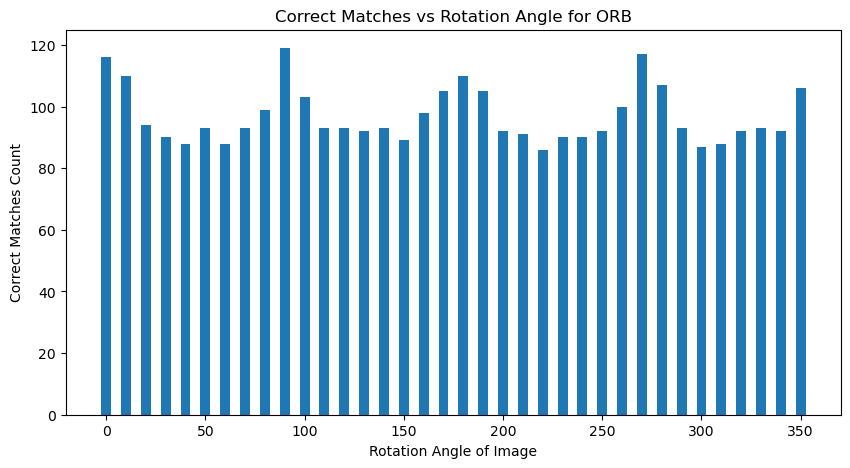

In [156]:
# Bar plot of the results with larger bar width:
plt.figure(figsize=(10, 5))
plt.bar(range(0, 360, 10), orb_result_counts, width=5)
plt.xlabel('Rotation Angle of Image')
plt.ylabel('Correct Matches Count')
plt.title('Correct Matches vs Rotation Angle for ORB')
plt.show()

## <img src="https://img.icons8.com/dusk/64/000000/prize.png" style="height:50px;display:inline"> References & Credits
* [1] P. Burt and E. Adelson. The Laplacian Pyramid as a Compact Image Code. IEEE
Transactions on Communications, 31(4):532{540, April 1983.
* [2] David G. Lowe. Distinctive Image Features from Scale-Invariant Keypoints. Inter-
national Journal of Computer Vision, 60(2):91{110, November 2004.
* [3] Michael Calonder, Vincent Lepetit, Christoph Strecha, and Pascal Fua. BRIEF: Binary Robust Independent Elementary Features.
* [4] Rublee, Ethan, Vincent Rabaud, Kurt Konolige, and Gary Bradski. "ORB: An efficient alternative to SIFT or SURF."
* Carnegie Mellon University - CMU
* Icons from <a href="https://icons8.com/">Icon8.com</a> - https://icons8.com
